In [ ]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [ ]:
p = Path("G:/CS/arwa-research/Kaggle-Autism-master/data/train")
dirs = p.glob("*")
labels_dict = {'Autistic': 0, 'Non_Autistic': 1}

image_data = []
labels = []

for folder_dir in dirs:
    label = str(folder_dir).split('\\')[-1]

    for img_path in folder_dir.glob("*.jpg"):
        img = image.load_img(img_path, target_size=(32, 32))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])


In [ ]:
print(len(image_data))
print(len(labels))

2643
2643


In [ ]:
## Convert data into numpy array

image_data = np.array(image_data, dtype='float32')/255.0
labels = np.array(labels)

print(image_data.shape, labels.shape)

(2643, 32, 32, 3) (2643,)


In [ ]:
## Randomly shuffle data

import random
combined = list(zip(image_data, labels))
random.shuffle(combined)

image_data[:], labels[:] = zip(*combined)

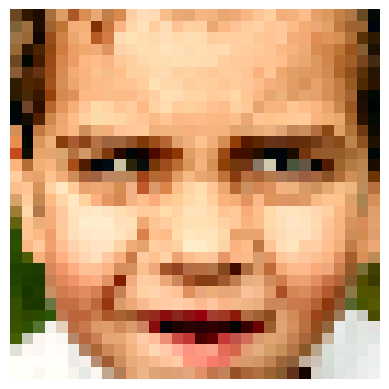

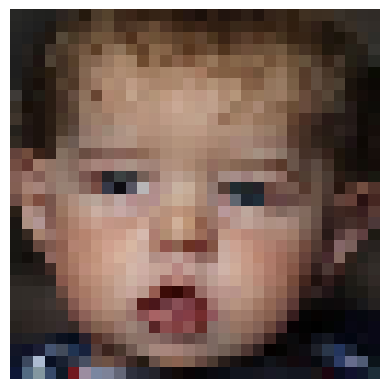

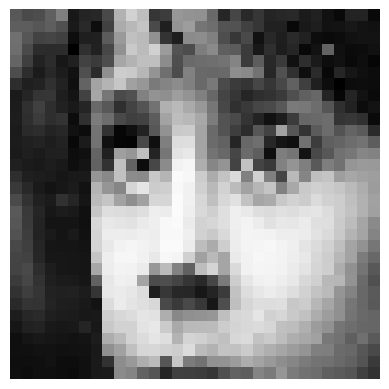

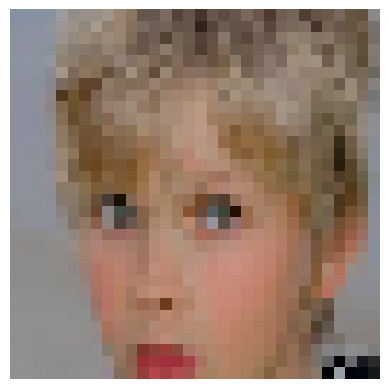

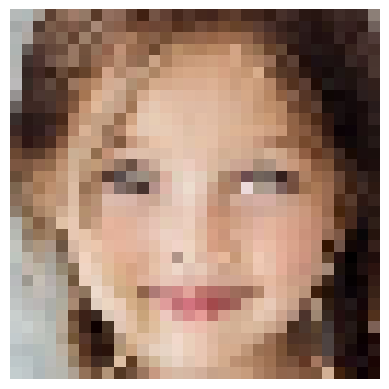

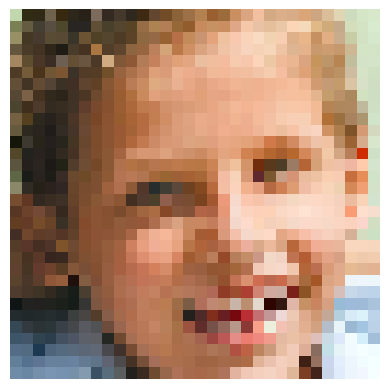

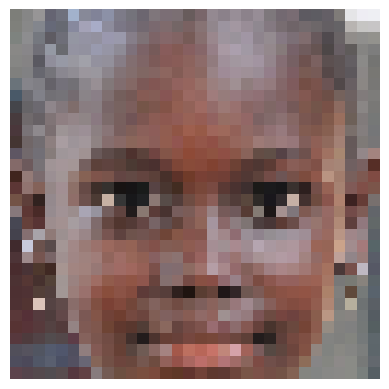

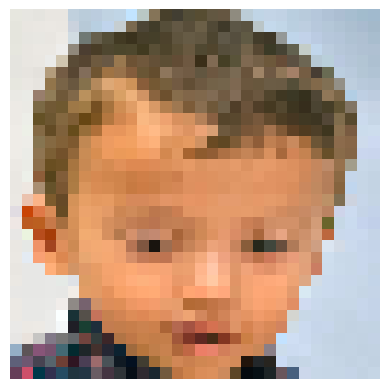

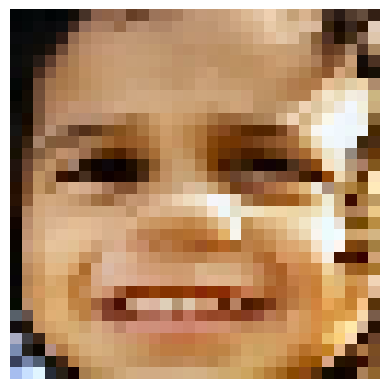

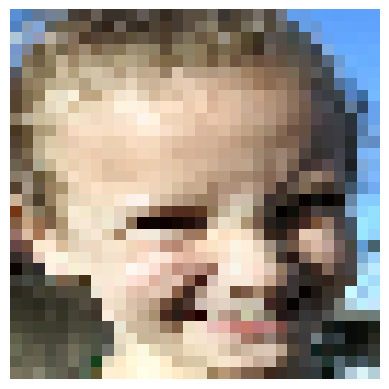

In [ ]:
## Visualize the data

def drawImg(img):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

for i in range(10):
    drawImg(image_data[i])

In [ ]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0

    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0

        loss += .5*np.dot(W,W.T)

        m = X.shape[0]

        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))

        return loss[0][0]

    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):

        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]

        n = learning_rate
        c = self.C

        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0

        #Initial Loss

        #Training from here...
        # Weight and Bias update rule
        losses = []

        for i in range(maxItr):
            #Training Loop

            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)

            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0

                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)

                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]

                W = W - n*W + n*gradw
                bias = bias + n*gradb

        self.W = W
        self.b = bias
        return W,bias,losses

In [ ]:
M = image_data.shape[0]
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

(2643, 3072)
(2643,)


In [ ]:
number_of_classes = len(np.unique(labels))

In [ ]:
def classWiseData(x, y):
    data = {}

    for i in range(number_of_classes):
        data[i] = []

    for i in range(x.shape[0]):
        data[y[i]].append(x[i])

    for k in data.keys():
        data[k] = np.array(data[k])

    return data

In [ ]:
data = classWiseData(image_data, labels)

In [ ]:
def getDataPairForSVM(d1,d2):

    l1,l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]

    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))

    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2

    data_labels[:l1] = -1
    data_labels[l1:] = 1

    return data_pair, data_labels

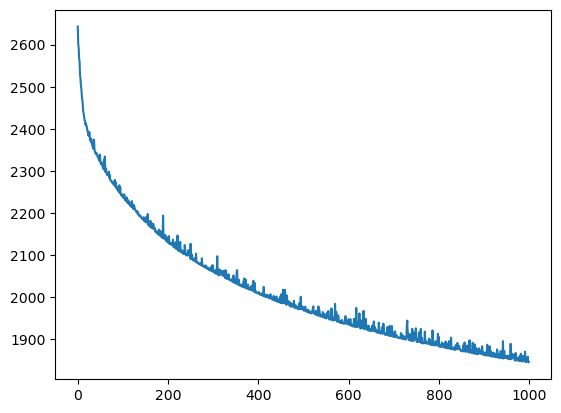

In [ ]:
mySVM = SVM()
xp, yp = getDataPairForSVM(data[0], data[1])
w,b,loss = mySVM.fit(xp,yp,learning_rate=0.00001,maxItr=1000)
plt.plot(loss)

In [ ]:
def trainSVMs(x,y):
    svm_classifiers = {}

    for i in range(number_of_classes):
        svm_classifiers[i] = {}
        for j in range(i+1, number_of_classes):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair, ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)

            plt.plot(loss)
            plt.show()

    return svm_classifiers

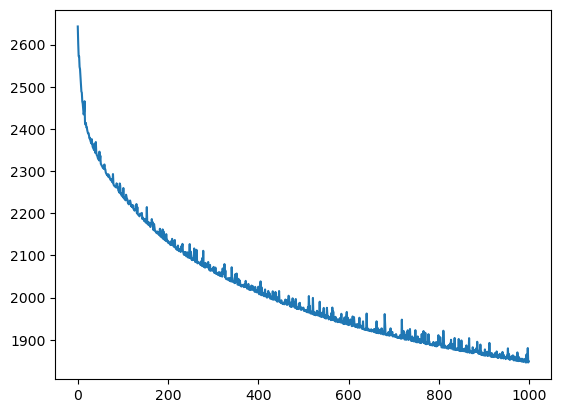

In [ ]:
svm_classifiers = trainSVMs(image_data, labels)

In [ ]:
cats_dogs = svm_classifiers[0][1]
print(cats_dogs[0].shape)
print(cats_dogs[1])

(1, 3072)
-0.2344300000000004


In [ ]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z >= 0:
        return 1
    else:
        return -1

In [ ]:
def predict(x):

    count = np.zeros((number_of_classes,))

    for i in range(number_of_classes):
        for j in range(i+1, number_of_classes):
            w,b = svm_classifiers[i][j]

            #Take a majority prediction
            z = binaryPredict(x,w,b)

            if z==1:
                count[j] += 1
            else:
                count[i] += 1

    final_prediction = np.argmax(count)
    return final_prediction

In [ ]:
print(predict(image_data[0]))
print(labels[0])

0
1


In [ ]:
def accuracy(x,y):

    pred = []
    count=0

    for i in range(x.shape[0]):
        prediction = predict(x[i])
        pred.append(prediction)
        if prediction==y[i]:
            count += 1

    return count/x.shape[0], pred

In [ ]:
acc, ypred = accuracy(image_data, labels)
print(acc)

0.6882330684827848
